# **Controle Inteligente de semáforo em um cruzamento urbano**


---

Foram realizados testes que inicialmente comparam o impacto do parametro alpha no treinamento do agente, e sequencialmente, comparam o agente treinado com um semáforo fixo e um aleatório, visando confirmar a hipótese inicial, de que um agente treinado por meio de DQL é capaz de resolver melhor o problema do que seus adversários.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Criação do ambiente
Simula um semáforo simples em um cruzamento com duas filas de carros. O agente devera ser capaz de decidir quando trocar o sinal de modo que miniminize o tamanho das filas, reduzindo o tempo de espera dos carros

In [ ]:
import random

class SemaforoEnv:
    def __init__(self):
        self.max_fila = 10
        self.max_steps = 200
        self.reset()

    def reset(self):
        self.fila_A = random.randint(0, 5)
        self.fila_B = random.randint(0, 5)
        self.sinal = random.choice([0, 1])  # 0 = A verde, 1 = B verde
        self.steps = 0
        return self._get_state()

    def step(self, action):
        self.steps += 1
        troca_penalty = 0

        # ação
        if action == 1:  # trocar sinal
            self.sinal = 1 - self.sinal
            troca_penalty = -0.5

        # carros passam
        if self.sinal == 0 and self.fila_A > 0:
            self.fila_A -= 1
        elif self.sinal == 1 and self.fila_B > 0:
            self.fila_B -= 1

        # chegada de carros
        if random.random() < 0.5 and self.fila_A < self.max_fila:
            self.fila_A += 1
        if random.random() < 0.5 and self.fila_B < self.max_fila:
            self.fila_B += 1

        # recompensa
        reward = - (self.fila_A + self.fila_B) / self.max_fila + troca_penalty

        # fim do episódio
        done = self.steps >= self.max_steps

        return self._get_state(), reward, done

    def _get_state(self):
        return (self.fila_A, self.fila_B, self.sinal)


Teste de ambiente, simulação rápida usando ações aleatórias

In [ ]:
env = SemaforoEnv()
estado = env.reset()

for _ in range(10):
    action = random.choice([0, 1])
    estado, recompensa, done = env.step(action)
    print("Estado:", estado, "Recompensa:", recompensa)


Estado: (3, 3, 0) Recompensa: -0.6
Estado: (3, 3, 0) Recompensa: -0.6
Estado: (2, 4, 0) Recompensa: -0.6
Estado: (1, 5, 0) Recompensa: -0.6
Estado: (2, 4, 1) Recompensa: -1.1
Estado: (3, 3, 1) Recompensa: -0.6
Estado: (2, 4, 0) Recompensa: -1.1
Estado: (3, 4, 1) Recompensa: -1.2
Estado: (4, 4, 1) Recompensa: -0.8
Estado: (4, 3, 1) Recompensa: -0.7


# Função para treinamento do agente
Pormeio dela, é possivel testar diferentes parâmetros de forma mais eficaz, será usada para comparar diferentes configurações e escolher o melhor agente para avaliação. Nesse experimento, estaremos modificando apenas o alpha.

In [ ]:
def treinar_q_learning(alpha, gamma, epsilon_decay):
    env = SemaforoEnv()
    Q = np.zeros((11, 11, 2, 2))
    epsilon = 1.0
    epsilon_min = 0.05

    episodios = 500
    recompensas = []

    for ep in range(episodios):
        estado = env.reset()
        recompensa_total = 0

        while True:
            if random.random() < epsilon:
                acao = random.choice([0, 1])
            else:
                acao = np.argmax(Q[estado[0], estado[1], estado[2]])

            novo_estado, recompensa, done = env.step(acao)

            Q[estado[0], estado[1], estado[2], acao] += alpha * (
                recompensa +
                gamma * np.max(Q[novo_estado[0], novo_estado[1], novo_estado[2]]) -
                Q[estado[0], estado[1], estado[2], acao]
            )

            estado = novo_estado
            recompensa_total += recompensa

            if done:
                break

        recompensas.append(recompensa_total)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    return Q, recompensas


Teste de diferentes configurações de alpha

In [ ]:
configs = [
    ("alpha=0.05", 0.05, 0.9, 0.995),
    ("alpha=0.1",  0.1,  0.9, 0.995),
    ("alpha=0.3",  0.3,  0.9, 0.995)
]

resultados = {}

for nome, alpha, gamma, decay in configs:
    Q, recompensas = treinar_q_learning(alpha, gamma, decay)
    resultados[nome] = np.mean(recompensas[-50:])


Exibição de gráfico comparando o desempenho dos diferentes valores de alpha

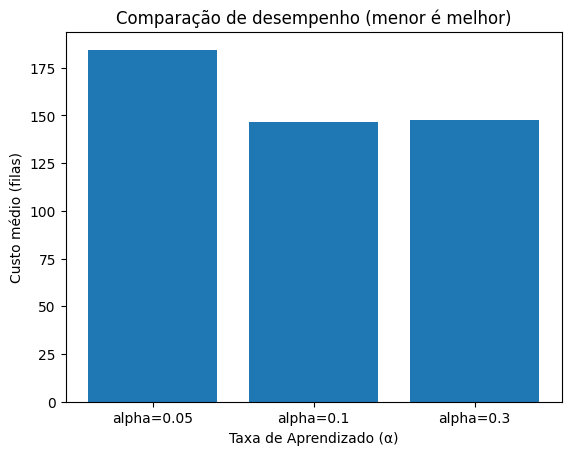

In [ ]:
valores_plot = [-v for v in resultados.values()]

plt.bar(resultados.keys(), valores_plot)
plt.xlabel("Taxa de Aprendizado (α)")
plt.ylabel("Custo médio (filas)")
plt.title("Comparação de desempenho (menor é melhor)")
plt.show()


É possível notar que o alpha = 0.05, resultou em um custo maior das filas, enquanto alpha = 0.1 e alpha = 0.3 mantiveram um resultado muito próximo. Portanto vamos realizar um teste mais ambrangente entre os dois para decidir qual será utilizado no treinamento do agente final.

# Teste comparativo de alpha 0.1 e 0.3

In [ ]:
def avaliar_config(alpha, gamma, decay, runs=10):
    medias = []
    for _ in range(runs):
        _, recompensas = treinar_q_learning(alpha, gamma, decay)
        medias.append(np.mean(recompensas[-50:]))
    return np.mean(medias), np.std(medias)

configs_finais = [
    ("alpha=0.1", 0.1, 0.9, 0.995),
    ("alpha=0.3", 0.3, 0.9, 0.995)
]

for nome, a, g, d in configs_finais:
    media, std = avaliar_config(a, g, d)
    print(f"{nome}: média = {media:.2f}, desvio = {std:.2f}")


alpha=0.1: média = -161.34, desvio = 7.34
alpha=0.3: média = -153.75, desvio = 5.96


Mesmo com uma diferença pequena, alpha = 0.3 se mostrou mais eficiente para esse ambiente, logo, iremos utiliza-lo no treinamento do agente final.

# Treinamento do Agente Final
o Agente final será treinado com o parametro alpha 0.3, as recompensas por episódio serão registradas e por fim um gráfico será plotado para melhor vizualização do processo de aprendizado do Agente.

In [ ]:
# parâmetros finais escolhidos
alpha = 0.3
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

# ambiente e Q-table final
env = SemaforoEnv()
Q_final = np.zeros((11, 11, 2, 2))

episodios = 1000  # pode usar mais agora
recompensas_finais = []

for ep in range(episodios):
    estado = env.reset()
    recompensa_total = 0

    while True:
        # política epsilon-greedy
        if random.random() < epsilon:
            acao = random.choice([0, 1])
        else:
            acao = np.argmax(Q_final[estado[0], estado[1], estado[2]])

        novo_estado, recompensa, done = env.step(acao)

        # atualização Q-learning
        Q_final[estado[0], estado[1], estado[2], acao] += alpha * (
            recompensa +
            gamma * np.max(Q_final[novo_estado[0], novo_estado[1], novo_estado[2]]) -
            Q_final[estado[0], estado[1], estado[2], acao]
        )

        estado = novo_estado
        recompensa_total += recompensa

        if done:
            break

    recompensas_finais.append(recompensa_total)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


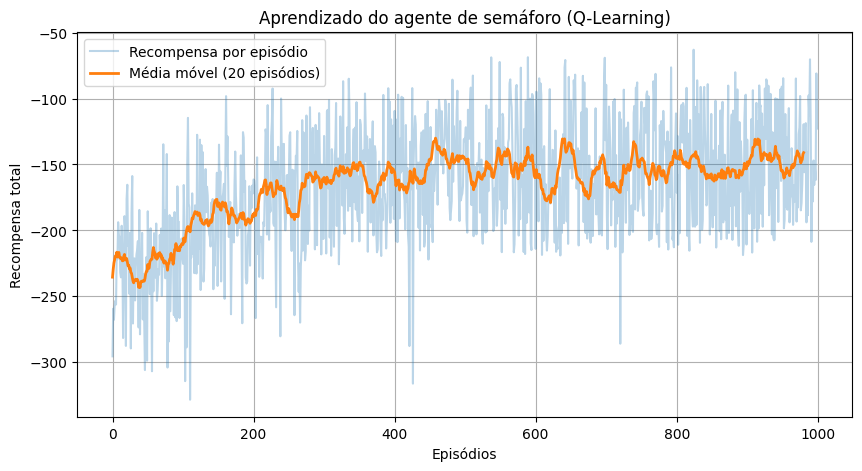

In [ ]:
window = 20

media_movel = np.convolve(
    recompensas_finais,
    np.ones(window) / window,
    mode="valid"
)

plt.figure(figsize=(10, 5))

# curva original (ruidosa)
plt.plot(
    recompensas_finais,
    alpha=0.3,
    label="Recompensa por episódio"
)

# curva suavizada
plt.plot(
    media_movel,
    linewidth=2,
    label=f"Média móvel ({window} episódios)"
)

plt.xlabel("Episódios")
plt.ylabel("Recompensa total")
plt.title("Aprendizado do agente de semáforo (Q-Learning)")
plt.legend()
plt.grid()
plt.show()


# Análise do Gráfico

Uma vez que a média móvel claramente sobe com o tempo, concluímos que o agente está aprendendo a melhorar a recompensa, reduzindo o tamanho das filas. também é possível notar uma diminuição de ruído e grandes flutuações a medida que o aprendizado estabiliza.

# Definição de políticas para avaliar desempenho

Semáforo Fixo, Semáforo Aleátório, Semáforo Qlearning

In [ ]:
def politica_semaforo_fixo(env, troca_a_cada=10):
    estado = env.reset()
    recompensa_total = 0

    for step in range(env.max_steps):
        acao = 1 if step % troca_a_cada == 0 else 0
        estado, recompensa, done = env.step(acao)
        recompensa_total += recompensa
        if done:
            break

    return recompensa_total


def politica_aleatoria(env):
    estado = env.reset()
    recompensa_total = 0

    for _ in range(env.max_steps):
        acao = random.choice([0, 1])
        estado, recompensa, done = env.step(acao)
        recompensa_total += recompensa
        if done:
            break

    return recompensa_total


def avaliar_agente_qlearning(env, Q):
    estado = env.reset()
    recompensa_total = 0

    for _ in range(env.max_steps):
        acao = np.argmax(Q[estado[0], estado[1], estado[2]])
        estado, recompensa, done = env.step(acao)
        recompensa_total += recompensa
        if done:
            break

    return recompensa_total


In [ ]:
num_execucoes = 100

resultados_fixo = []
resultados_aleatorio = []
resultados_q = []

for _ in range(num_execucoes):
    env = SemaforoEnv()  # reinicia o ambiente
    resultados_fixo.append(politica_semaforo_fixo(env))
    resultados_aleatorio.append(politica_aleatoria(env))
    resultados_q.append(avaliar_agente_qlearning(env, Q_final))


In [ ]:
print("Semáforo Fixo:      {:.2f} ± {:.2f}".format(np.mean(resultados_fixo), np.std(resultados_fixo)))
print("Semáforo Aleatório:  {:.2f} ± {:.2f}".format(np.mean(resultados_aleatorio), np.std(resultados_aleatorio)))
print("Q-Learning:          {:.2f} ± {:.2f}".format(np.mean(resultados_q), np.std(resultados_q)))


Semáforo Fixo:      -199.90 ± 35.97
Semáforo Aleatório:  -238.79 ± 33.25
Q-Learning:          -145.87 ± 39.42


# Análise de Resultados

Como previsto pela hipótese inicial, o agente q_learning obteve melhor resultado em comparação com os outros semáforos, sendo capaz de resolver o ambiente, mantendo valores mais satisfatórios nas filas.